<a href="https://colab.research.google.com/github/Danika-Balas/LondonBikeshare/blob/main/LondonBikeshare_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting London Bike Share Rides

The target variable, "cnt", is the total number of bike share rides initiated in a given hour in London. 
The dataset was compiled by Hristo Mavrodiev using the TfL Open Data: https://cycling.data.tfl.gov.uk/
The dataset is located here: https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

## Preprocessing and Setup

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import linear_model

## Upload data in Colab

In [3]:
#read train dataset into colab from local drive
from google.colab import files
upload1 = files.upload()

Saving LondonBikeshare.csv to LondonBikeshare.csv


In [4]:
#store datasets as pandas dataframes
import io
df = pd.read_csv(io.BytesIO(upload1['LondonBikeshare.csv']))

In [5]:
# # Read in data as dataframe if stored locally
# df = pd.read_csv("LondonBikeshare.csv")

In [6]:
df.head()

,timestamp,cnt,temp,tempfeel,humidity,windspeed,weather_code,is_holiday,is_weekend,season
0,1/4/15 0:00,182,3.0,2.0,93.0,6.0,3,0,1,3
1,1/4/15 1:00,138,3.0,2.5,93.0,5.0,1,0,1,3
2,1/4/15 2:00,134,2.5,2.5,96.5,0.0,1,0,1,3
3,1/4/15 3:00,72,2.0,2.0,100.0,0.0,1,0,1,3
4,1/4/15 4:00,47,2.0,0.0,93.0,6.5,1,0,1,3


### Feature Engineering

In [7]:
# Extract hour from timestamp
df['hour'] = df['timestamp'].str[-5:-3]
df['hour'] = df['hour'].str.strip()
df['hour'] = df['hour'].astype(int)

# Extract month from timestamp
df['month'] = df['timestamp'].str[:2]
df['month'] = df['month'].str.replace('/','')
df['month'] = df['month'].astype(int)

# Drop timestamp from df
df = df.drop('timestamp',1)

df.head()

,cnt,temp,tempfeel,humidity,windspeed,weather_code,is_holiday,is_weekend,season,hour,month
0,182,3.0,2.0,93.0,6.0,3,0,1,3,0,1
1,138,3.0,2.5,93.0,5.0,1,0,1,3,1,1
2,134,2.5,2.5,96.5,0.0,1,0,1,3,2,1
3,72,2.0,2.0,100.0,0.0,1,0,1,3,3,1
4,47,2.0,0.0,93.0,6.5,1,0,1,3,4,1


### EDA

In [8]:
# Count null values in each column
df.isnull().sum()

cnt             0
temp            0
tempfeel        0
humidity        0
windspeed       0
weather_code    0
is_holiday      0
is_weekend      0
season          0
hour            0
month           0
dtype: int64

In [9]:
# summary statistics
round(df.describe(),2)

,cnt,temp,tempfeel,humidity,windspeed,weather_code,is_holiday,is_weekend,season,hour,month
count,17414.00,17414.00,17414.00,17414.00,17414.00,17414.00,17414.00,17414.00,17414.00,17414.00,17414.00
mean,1143.10,12.47,11.52,72.32,15.91,2.72,0.02,0.29,1.49,11.51,6.51
std,1085.11,5.57,6.62,14.31,7.89,2.34,0.15,0.45,1.12,6.92,3.45
min,0.00,-1.50,-6.00,20.50,0.00,1.00,0.00,0.00,0.00,0.00,1.00
25%,257.00,8.00,6.00,63.00,10.00,1.00,0.00,0.00,0.00,6.00,4.00
50%,844.00,12.50,12.50,74.50,15.00,2.00,0.00,0.00,1.00,12.00,7.00
75%,1671.75,16.00,16.00,83.00,20.50,3.00,0.00,1.00,2.00,18.00,10.00
max,7860.00,34.00,34.00,100.00,56.50,26.00,1.00,1.00,3.00,23.00,12.00


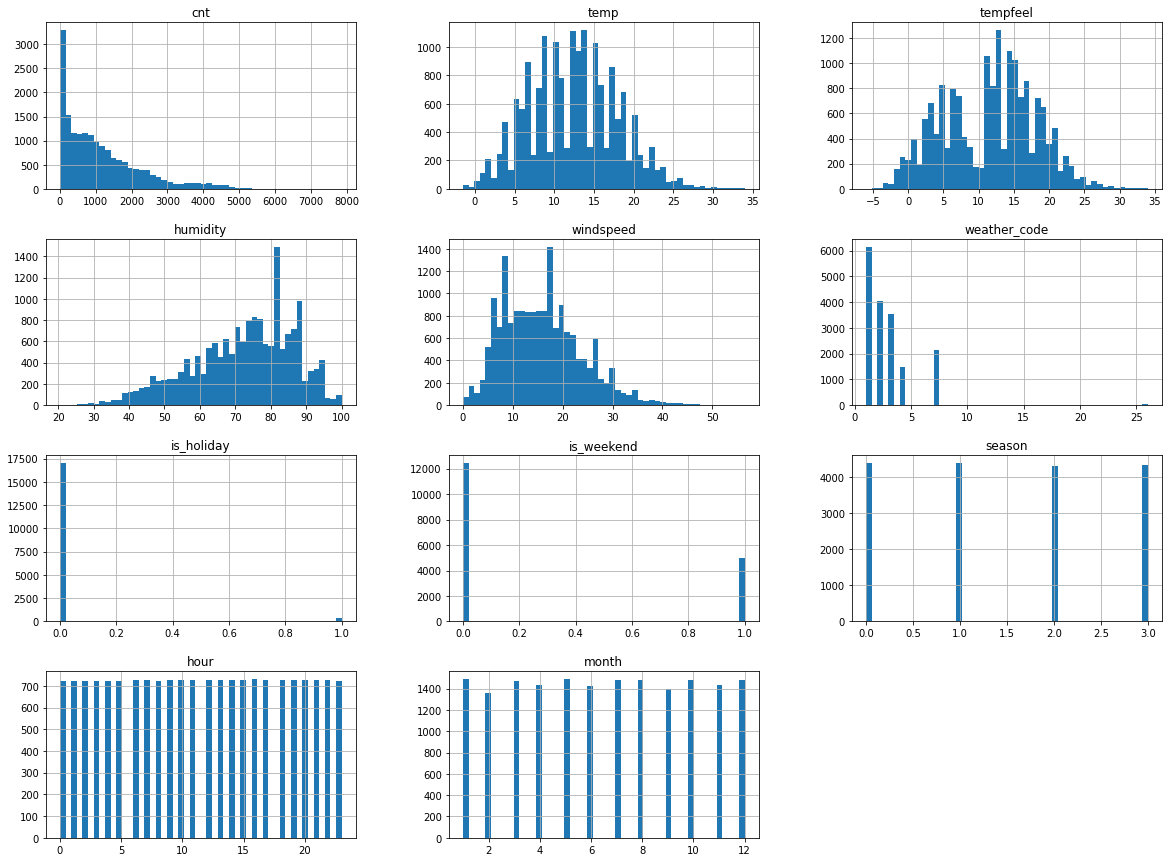

In [10]:
#histograms to get a first glimpse of the data
df.hist(bins=50, figsize=(20,15))
plt.show()

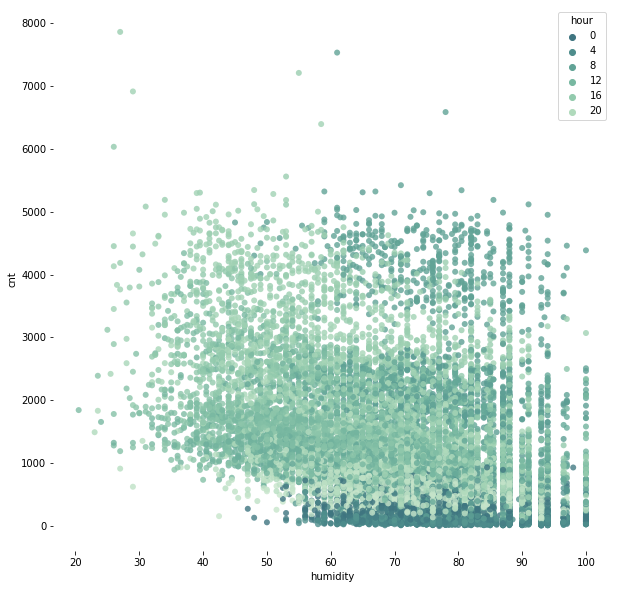

In [11]:
#Scatter plot of count vs humidity, colored by hour
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="humidity", y="cnt",
               hue="hour",
               palette="ch:r=-0.4, d=0.4_r",
               alpha=0.8, linewidth=0,
               data=df, ax=ax)

In [12]:
#Correlation of Count and other variables
corr_matrix = df.corr()
corr_matrix["cnt"].sort_values(ascending=False).head(15)

cnt             1.000000
temp            0.388798
tempfeel        0.369035
hour            0.324423
windspeed       0.116295
month           0.063757
is_holiday     -0.051698
is_weekend     -0.096499
season         -0.116180
weather_code   -0.166633
humidity       -0.462901
Name: cnt, dtype: float64

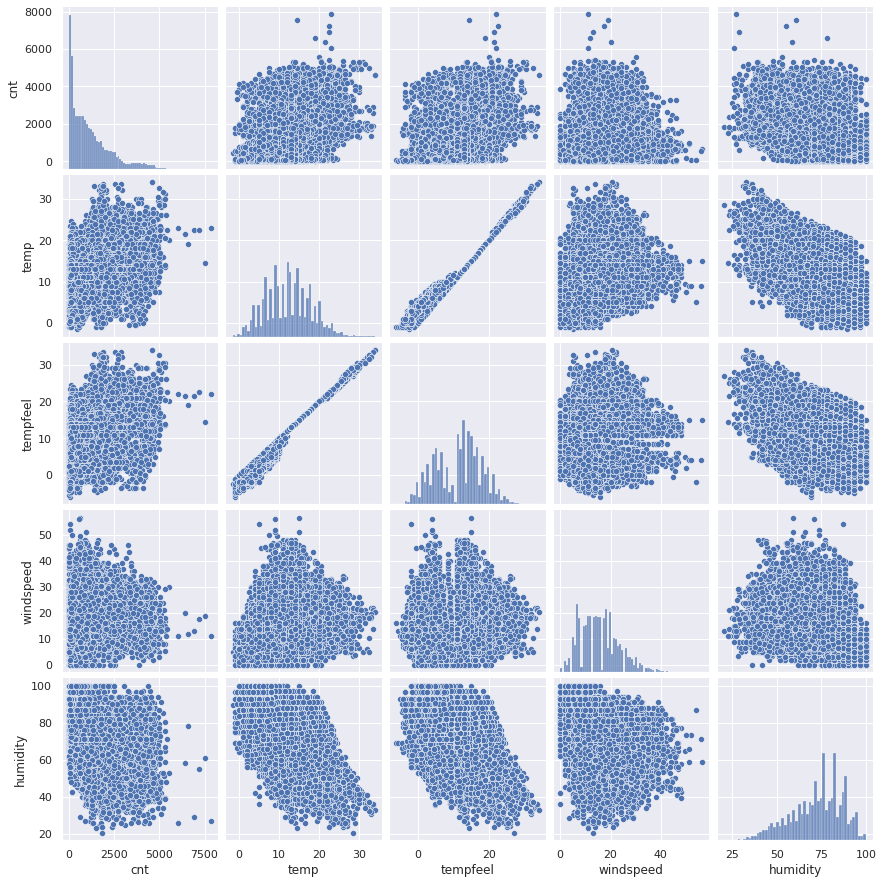

In [13]:
#Pair plots
sns.set()
attributes = ["cnt", "temp", "tempfeel", "windspeed", "humidity"]
sns.pairplot(df[attributes], height=2.5)
plt.show()

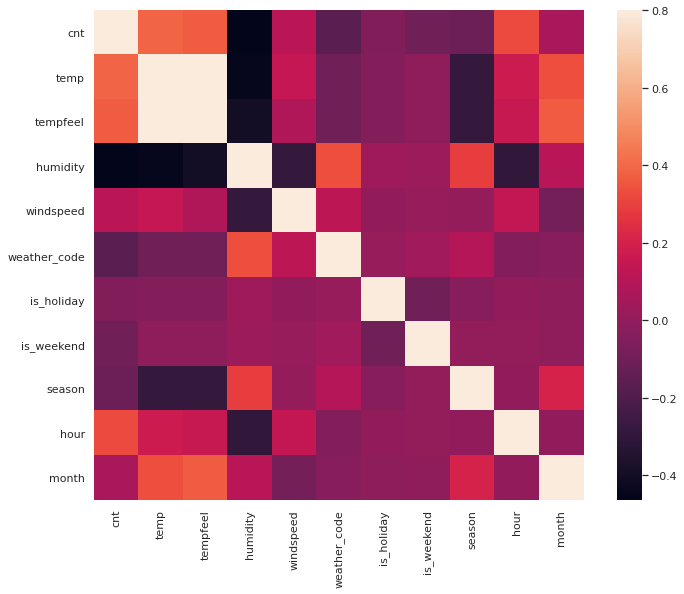

In [14]:
#Heat Map
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=.8, square=True)

## Prepare Data for Modeling

In [15]:
# Reduce dataset to variables with highest correlation with Count
# dropped tempfeel because of its close relationship to temp, 
# and because temp has higher correlation with Count

# NOTE: Hour and Month are categorical variables that should be transformed with one hot encoding.
# However, to demonstrate the flask app pipeline, we will leave them as is 
# for simplicity of entering parameters in the flask app

X_all = df[["temp", "windspeed", "hour", "month"]]
y_all = df[["cnt"]]

In [16]:
# Scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_all)
X_scaled = scaler.fit_transform(X_all)

In [17]:
# Split into train and test (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13931, 4), (3483, 4), (13931, 1), (3483, 1))

## Gradient Boosted Trees

In [177]:
# Model Count using gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=240)
gbrt.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=240,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [178]:
from sklearn import metrics

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))
y_pred = gbrt.predict(X_test)
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Accuracy on training set: 0.709
Accuracy on test set: 0.713
Root Mean Squared Error: 586.7312471333371


In [179]:
#Best ensemble from 5000 trees:
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=5000)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred)
          for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors)


gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1641,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [180]:
print("Accuracy on training set: {:.3f}".format(gbrt_best.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt_best.score(X_test, y_test)))

y_pred = gbrt_best.predict(X_test)
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Accuracy on training set: 0.726
Accuracy on test set: 0.717
Root Mean Squared Error: 582.5656240933137


In [181]:
from sklearn.externals import joblib
joblib.dump(gbrt_best,"gbrt.pkl")

['gbrt.pkl']

## Simple DNN

In [18]:
# Split into train, validation, and test sets (80/20)
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((11144, 4), (2787, 4), (3483, 4), (11144, 1), (2787, 1), (3483, 1))

In [19]:
# Scale training, validation, and test sets
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [20]:
import keras

In [27]:
model = keras.models.Sequential([
    keras.layers.Dense(4, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(400, activation="relu"),
    keras.layers.Dense(400, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer="adam")


In [28]:
history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_valid, y_valid))


Epoch 1/200
349/349 [==============================] - 2s 5ms/step - loss: 1767487.4882 - val_loss: 934207.9375
Epoch 2/200
349/349 [==============================] - 2s 4ms/step - loss: 884262.7234 - val_loss: 874309.5625
Epoch 3/200
349/349 [==============================] - 1s 4ms/step - loss: 844683.7739 - val_loss: 816117.6875
Epoch 4/200
349/349 [==============================] - 1s 4ms/step - loss: 804510.7203 - val_loss: 776870.0000
Epoch 5/200
349/349 [==============================] - 1s 4ms/step - loss: 750407.7760 - val_loss: 743455.3125
Epoch 6/200
349/349 [==============================] - 1s 4ms/step - loss: 728162.9781 - val_loss: 706149.0625
Epoch 7/200
349/349 [==============================] - 1s 4ms/step - loss: 682398.5864 - val_loss: 683843.3125
Epoch 8/200
349/349 [==============================] - 2s 4ms/step - loss: 662250.8821 - val_loss: 671364.8125
Epoch 9/200
349/349 [==============================] - 2s 4ms/step - loss: 668941.1523 - val_loss: 662838.1250


In [29]:
mse_test = model.evaluate(X_test, y_test)

109/109 [==============================] - 0s 1ms/step - loss: 348586.1875


In [30]:
X_new = X_test[:3] # pretend these are new instances
y_pred = model.predict(X_new)

In [31]:
y_pred

array([[  90.75666],
       [1472.0923 ],
       [ 266.28558]], dtype=float32)

In [32]:
y_test[:3]

,cnt
14097,66
10978,1749
7408,172


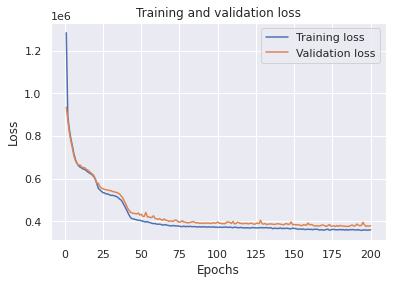

In [33]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Save model and scaler

In [39]:
model.save("LB_dnn_model.h5")

In [34]:
import joblib
joblib.dump(scaler,"LB_scaler.pkl")

['LB_scaler.pkl']

In [40]:
# Export files
from google.colab import files
files.download("LB_dnn_model.h5")
files.download("LB_scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>